# Feature Engineering

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Objectives - 
1. Feature Transformation
    - Categrical Variables
        - One Hot Encoding
        - Label Encoding
2. Feature Selection
3. Feature Extraction (using PCA)

In [2]:
import requests
            
path = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0232EN-SkillsNetwork/asset/airlines_data.xlsx"

response = requests.get(path)
with open('data/airlines_data.xlsx', 'wb') as f:
    f.write(response.content)
    
data = pd.read_excel('data/airlines_data.xlsx')
data.head()

Airline Date_of_Journey    Source Destination                  Route  \
0       IndiGo      24/03/2019  Banglore   New Delhi              BLR → DEL   
1    Air India       1/05/2019   Kolkata    Banglore  CCU → IXR → BBI → BLR   
2  Jet Airways       9/06/2019     Delhi      Cochin  DEL → LKO → BOM → COK   
3       IndiGo      12/05/2019   Kolkata    Banglore        CCU → NAG → BLR   
4       IndiGo      01/03/2019  Banglore   New Delhi        BLR → NAG → DEL   

  Dep_Time  Arrival_Time Duration Total_Stops Additional_Info  Price  
0    22:20  01:10 22 Mar   2h 50m    non-stop         No info   3897  
1    05:50         13:15   7h 25m     2 stops         No info   7662  
2    09:25  04:25 10 Jun      19h     2 stops         No info  13882  
3    18:05         23:30   5h 25m      1 stop         No info   6218  
4    16:50         21:35   4h 45m      1 stop         No info  13302

In [3]:
data.describe()

Price
count  10683.000000
mean    9087.064121
std     4611.359167
min     1759.000000
25%     5277.000000
50%     8372.000000
75%    12373.000000
max    79512.000000

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [5]:
data.isnull().sum()
# only one row has missing data in 2 columns

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [6]:
data = data.ffill()

## Feature Transformation

### Dealing with Categorical Data

In [7]:
data['Airline'].unique().tolist()

['IndiGo',
 'Air India',
 'Jet Airways',
 'SpiceJet',
 'Multiple carriers',
 'GoAir',
 'Vistara',
 'Air Asia',
 'Vistara Premium economy',
 'Jet Airways Business',
 'Multiple carriers Premium economy',
 'Trujet']

Notice that some Names are stll repeating. We can use np.where() to combine these names

In [8]:
data['Airline'] = np.where(data['Airline']=='Multiple carriers Premium economy', 'Multiple carriers', data['Airline'])
data['Airline'] = np.where(data['Airline']=='Vistara Premium economy', 'Vistara', data['Airline'])
data['Airline'] = np.where(data['Airline']=='Jet Airways Business', 'Jet Airways', data['Airline'])

In [9]:
data['Airline'].unique().tolist()

['IndiGo',
 'Air India',
 'Jet Airways',
 'SpiceJet',
 'Multiple carriers',
 'GoAir',
 'Vistara',
 'Air Asia',
 'Trujet']

In [10]:
data1 = pd.get_dummies(data, columns=['Airline', 'Source', 'Destination'])

In [11]:
data1.shape

(10683, 28)

In [12]:
data.shape

(10683, 11)

Notice the column count has increased

In [13]:
# for the column = Total_Stops. It is a numeric data stored as string
data['Total_Stops'].value_counts()

Total_Stops
1 stop      5625
non-stop    3492
2 stops     1520
3 stops       45
4 stops        1
Name: count, dtype: int64

In [14]:
data1.replace({'non-stop':0, '1 stop':1, '2 stops':2, '3 stops':3, '4 stops':4}, inplace=True)

/var/folders/28/y7rzw6bx5v50lt2qvk32ntxm0000gn/T/ipykernel_48254/2156632205.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data1.replace({'non-stop':0, '1 stop':1, '2 stops':2, '3 stops':3, '4 stops':4}, inplace=True)


## Date Time Transformations

Using Python loops we can iterate over elements and create new columns

In [15]:
duration = list(data1['Duration'])
for i in range(len(duration)) :
    if len(duration[i].split()) != 2:
        if 'h' in duration[i] :
            duration[i] = duration[i].strip() + ' 0m'
        elif 'm' in duration[i] :
            duration[i] = '0h {}'.format(duration[i].strip())
dur_hours = []
dur_minutes = []  
 
for i in range(len(duration)) :
    dur_hours.append(int(duration[i].split()[0][:-1]))
    dur_minutes.append(int(duration[i].split()[1][:-1]))
     
 
data1['Duration_hours'] = dur_hours
data1['Duration_minutes'] =dur_minutes
data1.loc[:,'Duration_hours'] *= 60
data1['Duration_Total_mins']= data1['Duration_hours']+data1['Duration_minutes']

In [16]:
# using to_dattime() we can perform operations on timestamp data
data1["Dep_Hour"]= pd.to_datetime(data1['Dep_Time']).dt.hour
data1["Dep_Min"]= pd.to_datetime(data1['Dep_Time']).dt.minute

/var/folders/28/y7rzw6bx5v50lt2qvk32ntxm0000gn/T/ipykernel_48254/3615047870.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data1["Dep_Hour"]= pd.to_datetime(data1['Dep_Time']).dt.hour
/var/folders/28/y7rzw6bx5v50lt2qvk32ntxm0000gn/T/ipykernel_48254/3615047870.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data1["Dep_Min"]= pd.to_datetime(data1['Dep_Time']).dt.minute


In [17]:
data1["Arrival_Hour"]= pd.to_datetime(data1['Arrival_Time']).dt.hour
data1["Arrival_Min"]= pd.to_datetime(data1['Arrival_Time']).dt.minute

/var/folders/28/y7rzw6bx5v50lt2qvk32ntxm0000gn/T/ipykernel_48254/999911604.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data1["Arrival_Hour"]= pd.to_datetime(data1['Arrival_Time']).dt.hour
/var/folders/28/y7rzw6bx5v50lt2qvk32ntxm0000gn/T/ipykernel_48254/999911604.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data1["Arrival_Min"]= pd.to_datetime(data1['Arrival_Time']).dt.minute


In [18]:
# splitting into timezones based on the Departure Hour
data1['dep_timezone'] = pd.cut(data1.Dep_Hour, [0,6,12,18,24], labels=['Night','Morning','Afternoon','Evening'])
data1['dep_timezone'] 

0          Evening
1            Night
2          Morning
3        Afternoon
4        Afternoon
           ...    
10678      Evening
10679      Evening
10680      Morning
10681      Morning
10682      Morning
Name: dep_timezone, Length: 10683, dtype: category
Categories (4, object): ['Night' < 'Morning' < 'Afternoon' < 'Evening']

In [19]:
# same with arrival column

data1["Arrival_Hour"]= pd.to_datetime(data1['Arrival_Time']).dt.hour
data1['arr_timezone'] = pd.cut(data1.Arrival_Hour, [0,6,12,18,24], labels=['Night','Morning','Afternoon','Evening'])
data1['arr_timezone']

/var/folders/28/y7rzw6bx5v50lt2qvk32ntxm0000gn/T/ipykernel_48254/3574099833.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data1["Arrival_Hour"]= pd.to_datetime(data1['Arrival_Time']).dt.hour


0            Night
1        Afternoon
2            Night
3          Evening
4          Evening
           ...    
10678      Evening
10679      Evening
10680      Morning
10681    Afternoon
10682      Evening
Name: arr_timezone, Length: 10683, dtype: category
Categories (4, object): ['Night' < 'Morning' < 'Afternoon' < 'Evening']

In [20]:
# creating date, day, month columns from Data of Journy column
data1['Month']= pd.to_datetime(data1["Date_of_Journey"], format="%d/%m/%Y").dt.month
data1['Day']= pd.to_datetime(data1["Date_of_Journey"], format="%d/%m/%Y").dt.day
data1['Year']= pd.to_datetime(data1["Date_of_Journey"], format="%d/%m/%Y").dt.year

In [21]:
data1['day_of_week'] = pd.to_datetime(data1['Date_of_Journey']).dt.day_name()

/var/folders/28/y7rzw6bx5v50lt2qvk32ntxm0000gn/T/ipykernel_48254/401715484.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data1['day_of_week'] = pd.to_datetime(data1['Date_of_Journey']).dt.day_name()


## Feature Selection

In [22]:
# this the new data with the now transformed columns
data1.columns

Index(['Date_of_Journey', 'Route', 'Dep_Time', 'Arrival_Time', 'Duration',
       'Total_Stops', 'Additional_Info', 'Price', 'Airline_Air Asia',
       'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Multiple carriers', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Source_Banglore',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Banglore', 'Destination_Cochin', 'Destination_Delhi',
       'Destination_Hyderabad', 'Destination_Kolkata', 'Destination_New Delhi',
       'Duration_hours', 'Duration_minutes', 'Duration_Total_mins', 'Dep_Hour',
       'Dep_Min', 'Arrival_Hour', 'Arrival_Min', 'dep_timezone',
       'arr_timezone', 'Month', 'Day', 'Year', 'day_of_week'],
      dtype='object')

In [23]:
new_data = data1.loc[:,['Total_Stops', 'Airline_Air Asia',
       'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Multiple carriers', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Source_Banglore',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Banglore', 'Destination_Cochin', 'Destination_Delhi',
       'Destination_Hyderabad', 'Destination_Kolkata', 'Destination_New Delhi',
       'Duration_hours', 'Duration_minutes', 'Duration_Total_mins', 'Dep_Hour',
       'Dep_Min', 'Price']]

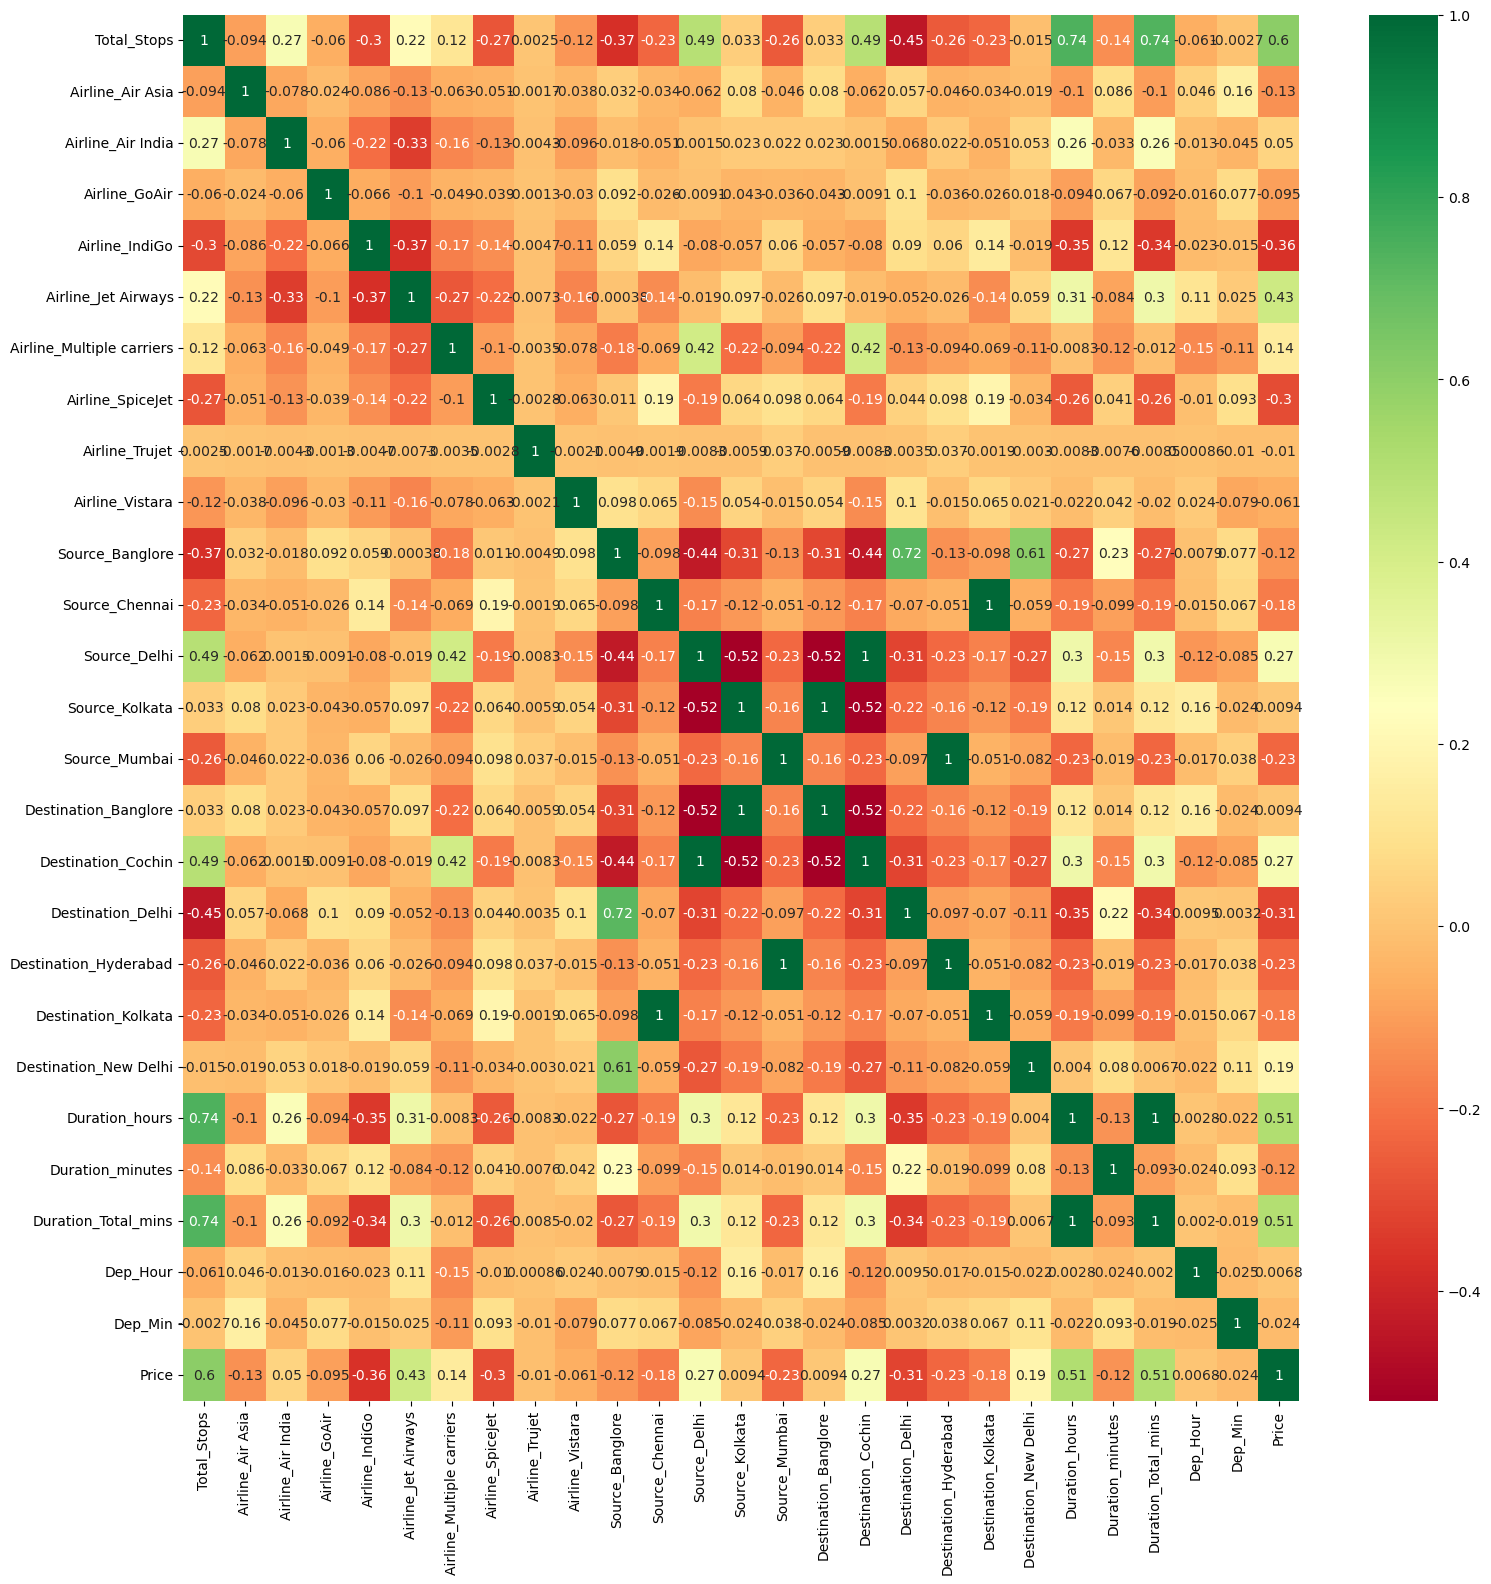

In [24]:
plt.figure(figsize=(18,18))
sns.heatmap(new_data.corr(),annot=True,cmap='RdYlGn')

plt.show()

In [25]:
# calculate correlation with Price
features = new_data.corr()['Price'].sort_values()
features

Airline_IndiGo              -0.361048
Destination_Delhi           -0.313401
Airline_SpiceJet            -0.296552
Destination_Hyderabad       -0.230745
Source_Mumbai               -0.230745
Destination_Kolkata         -0.179216
Source_Chennai              -0.179216
Airline_Air Asia            -0.133044
Duration_minutes            -0.124874
Source_Banglore             -0.118026
Airline_GoAir               -0.095146
Airline_Vistara             -0.060503
Dep_Min                     -0.024492
Airline_Trujet              -0.010380
Dep_Hour                     0.006819
Source_Kolkata               0.009377
Destination_Banglore         0.009377
Airline_Air India            0.050346
Airline_Multiple carriers    0.141087
Destination_New Delhi        0.189785
Destination_Cochin           0.270619
Source_Delhi                 0.270619
Airline_Jet Airways          0.428490
Duration_Total_mins          0.506371
Duration_hours               0.508672
Total_Stops                  0.603891
Price       

<Axes: >

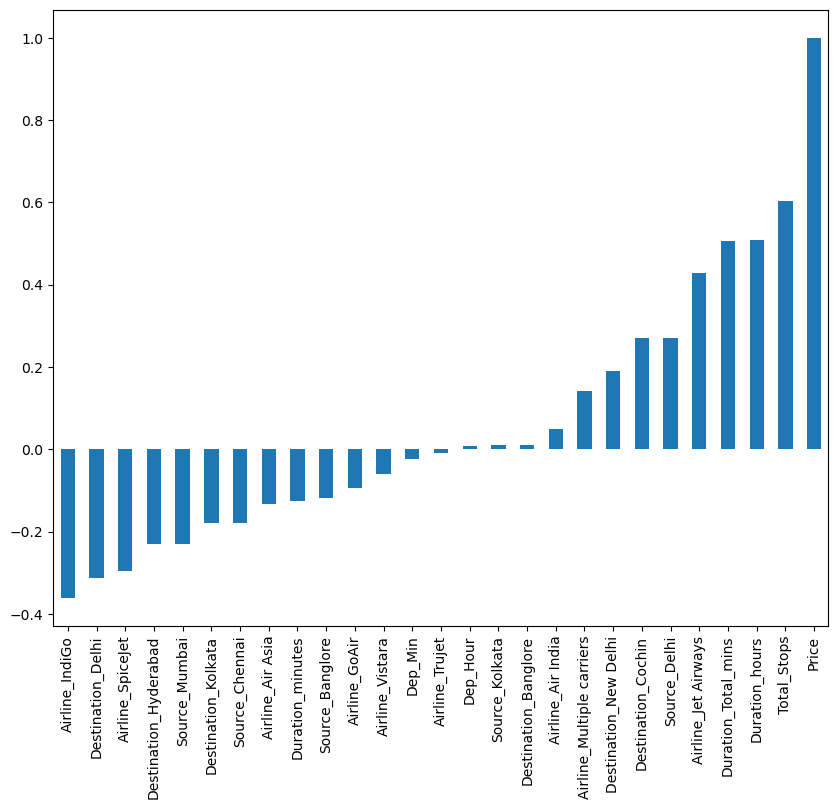

In [26]:
features.plot(kind='bar',figsize=(10,8))

# Principal Component Analysis

In [27]:
x = data1.loc[:,['Total_Stops', 'Airline_Air Asia',
       'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Multiple carriers', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Source_Banglore',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Banglore', 'Destination_Cochin', 'Destination_Delhi',
       'Destination_Hyderabad', 'Destination_Kolkata', 'Destination_New Delhi',
       'Duration_hours', 'Duration_minutes', 'Duration_Total_mins', 'Dep_Hour',
       'Dep_Min']]

In [28]:
y= data1.Price

In [29]:
scaler = StandardScaler()
x=scaler.fit_transform(x.astype(np.float64))
x

array([[-1.22052384, -0.17544122, -0.44291155, ..., -0.93158255,
         1.65425948, -0.23505036],
       [ 1.74150619, -0.17544122,  2.25778713, ..., -0.39007152,
        -1.30309491,  1.36349161],
       [ 1.74150619, -0.17544122, -0.44291155, ...,  0.97847452,
        -0.60724682,  0.0313733 ],
       ...,
       [-1.22052384, -0.17544122, -0.44291155, ..., -0.91189124,
        -0.78120884, -0.23505036],
       [-1.22052384, -0.17544122, -0.44291155, ..., -0.95127386,
        -0.25932278,  0.29779696],
       [ 1.74150619, -0.17544122,  2.25778713, ..., -0.28176932,
        -0.4332848 ,  1.62991527]], shape=(10683, 26))

In [30]:
# this selects 2 principal components

pca = PCA(n_components = 2)
pca.fit_transform(x)

array([[-2.87559235, -0.55520415],
       [ 0.31882945,  2.39235354],
       [ 3.05931822, -0.52686459],
       ...,
       [-2.24752702, -0.58854579],
       [-2.69895755, -0.28856263],
       [ 1.92548188, -1.10426513]], shape=(10683, 2))

Explained Variance Ratio

With this we can see how much of variance in the dataset is contributed by a feature

In [31]:
explained_variance=pca.explained_variance_ratio_
explained_variance

array([0.17545521, 0.12110719])

In [32]:
pca = PCA(n_components = 7)
pca.fit_transform(x)
explained_variance=pca.explained_variance_ratio_
explained_variance

array([0.17545521, 0.12110719, 0.0926492 , 0.08280111, 0.06739565,
       0.05275645, 0.04819544])

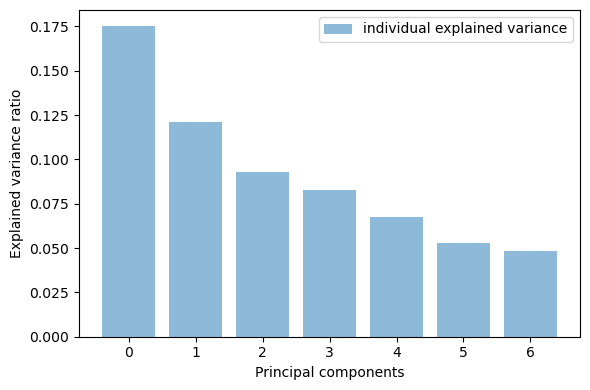

In [33]:
plt.figure(figsize=(6, 4))

plt.bar(range(7), explained_variance, alpha=0.5, align='center',
label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout() 

Choosing the right number of features to scale down to.

It be better to mathematically choose the number of features based on the CUMMUATIVE SUM of variance accountable to features.

In [34]:
# choose the features until a variance of 95% is reached
pca = PCA()
pca.fit(x)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >=0.95) + 1

In [35]:
d

np.int64(16)

In [36]:
# you can specify the variance to n_components which you want to preserve
pca = PCA(n_components=0.95)
x_reduced = pca.fit_transform(x)

In [37]:
# graphical way to visualize how variance changes with increase in features for this dataset

px.area(
    x=range(1, cumsum.shape[0] + 1),
    y=cumsum,
    labels={"x": "# Components", "y": "Explained Variance"}
)